Semi-supervised learning.  
Predicting-future CAE network
Use 3d spatio-temporal conv kernels.  

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

from SemiNE3d.utils import *
from SemiNE3d.train import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 100
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=2e-4 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')
movie_bgr_h5 = np.load('../data/fig5_movie_bgr_h5.npy')

In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*1800:ii*1800+1800] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[36000:39200]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[39200:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of train_loader[0][2]:
(1800, 2, 9, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of val_loader[2]:
(3200, 2, 9, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)
shape of test_loader[2]:
(800, 2, 9, 28, 28)


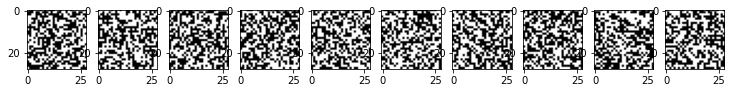

In [6]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

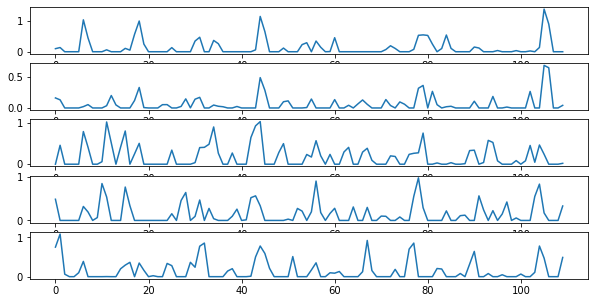

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

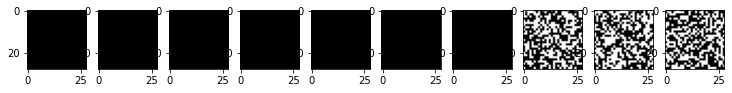

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

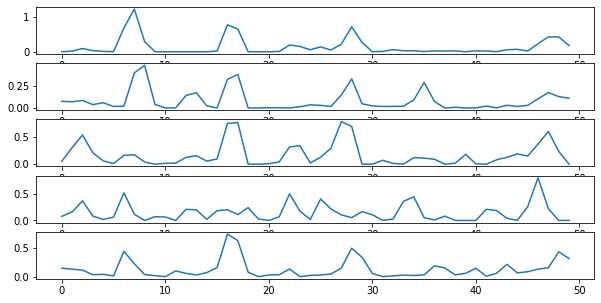

In [9]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(test_loader[1][:,ii])
    #axes[ii].grid(False)#axes[ii,jj].axis('tight')

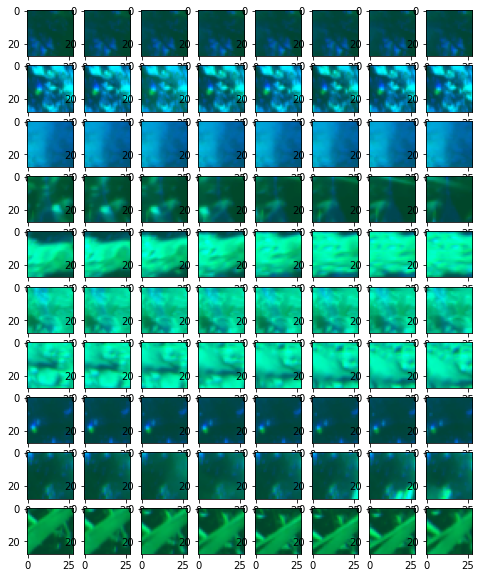

In [10]:
fig, axes = plt.subplots(nrows=10, ncols=8,figsize=(8,10))
for ii in range(10):
    for jj in range(8):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.transpose(train_loader[10][2][ii][:,jj,:,:],(1,2,0))[...,::-1]
        axes[ii,jj].imshow(img_real2view(temp))
        axes[ii,jj].grid(False)#axes[ii,jj].axis('tight')

In [11]:
#preprocess: centered data
sky_bg_mean_f   =np.mean(movie_bgr_h5[:36000,:,:7,:,:],axis=(0,2,3,4))/255.0
print(sky_bg_mean_f)

[0.1940663  0.20585608]


In [12]:
temp=np.zeros((28,28,3),np.uint8)
temp[...,0]=int(sky_bg_mean_f[0]*255)
temp[...,1]=int(sky_bg_mean_f[1]*255)
#cv2.imwrite('out_result/last_frame.tif',img_real2view(temp))

In [13]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = 8 # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

##  <font color='red'>Model architecture</font> 

In [14]:
class ModelSemiSL3d1_Conv3d_2(nn.Module):
    def __init__(self):
        super().__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #
        self.ae_dconv1 =nn.ConvTranspose2d(self.numoffea,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            #GaussianNoise(sigma=0)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten(-1,self.numoffea,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_Conv3d_2_copy(nn.Module):
    def __init__(self,conv1,conv1_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1.data.copy_(conv1.clone().detach())
        self.conv1_bias.data.copy_(conv1_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=2e-4 # 1e-4
alpha1s = [1e2] # [1e2]
alpha2s = [0] #not play a role
beta1s  =[1/16] # [1/4]
alpha3s =[1e3, 1e4, 1e5] # [1e3]
beta2s  =[0, 1/16, 1/4]
seeds   =[1]
lossweights=[0.6, 0.5, 0.4, 0.3] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
modelvalloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
modeltestloss=np.zeros((len(alpha3s), len(beta2s), len(lossweights)))
for ii in range(len(alpha3s)):
    for jj in range(len(beta2s)):
        for kk in range(len(lossweights)):
            torch.manual_seed(seeds[0])    # reproducible
            torch.cuda.manual_seed(seeds[0])
            tempmodel = ModelSemiSL3d1_Conv3d_2()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[ii],beta2=beta2s[jj],lossweight=lossweights[kk],earlystop=True,verbose=False) 
            #torch.save(tempmodel.state_dict(),\
            #       './out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            print ('Val CC: {}'.format(temp))
            modelvalloss[ii,jj,kk]=temp
            temp,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            #print (temp)
            modeltestloss[ii,jj,kk]=temp
            del tempmodel
            torch.cuda.empty_cache()

2021-01-21 19:37:30.702475
Epoch: 49 val loss: 0.2867, finish training!
2021-01-21 20:15:47.154438
Val CC: 0.2866663317743081
Overall pearson correlation coefficient:  0.4778383605419278  and p-value:  1.5364566527749177e-234
2021-01-21 20:15:57.216243
Epoch: 55 val loss: 0.2886, finish training!
2021-01-21 20:58:58.998926
Val CC: 0.28863167373726567
Overall pearson correlation coefficient:  0.48153481838091494  and p-value:  1.1383412259937848e-238
2021-01-21 20:59:09.236116
Epoch: 64 val loss: 0.2911, finish training!
2021-01-21 21:49:38.326871
Val CC: 0.29114109238312014
Overall pearson correlation coefficient:  0.48796394074362626  and p-value:  5.631029175626048e-246
2021-01-21 21:49:48.838231
Epoch: 77 val loss: 0.2901, finish training!
2021-01-21 22:49:50.055027
Val CC: 0.29009980649974376
Overall pearson correlation coefficient:  0.4884008049778178  and p-value:  1.7720220526554962e-246
2021-01-21 22:50:00.067685


In [21]:
#beta1s  =[1/16] # [1/4]
#alpha3s =[1e3, 1e4, 1e5] 
#beta2s  =[0, 1/16, 1/4]
#seeds   =[1]
#lossweights=[0.6, 0.5, 0.4, 0.3]
print (np.max(modelvalloss))
print (np.argmax(modelvalloss))
print (modelvalloss)
print (np.max(modeltestloss))
print (np.argmax(modeltestloss))
print (modeltestloss)

0.31450451808142327
18
[[[0.28666633 0.28863167 0.29114109 0.29009981]
  [0.28559699 0.28632079 0.29043079 0.28914838]
  [0.28561197 0.28871524 0.29144928 0.29177622]]

 [[0.29685562 0.3038007  0.31318111 0.31094308]
  [0.29787267 0.30478274 0.31450452 0.30761488]
  [0.29665677 0.30524381 0.31262606 0.30442419]]

 [[0.23286931 0.23263326 0.23255217 0.23249494]
  [0.23247944 0.23225056 0.23208258 0.23219616]
  [0.23197505 0.23170085 0.23163631 0.23179474]]]
0.5408611980236986
22
[[[0.47783836 0.48153482 0.48796394 0.4884008 ]
  [0.47757928 0.4765179  0.48112691 0.4843315 ]
  [0.47455428 0.48587655 0.49764019 0.50111746]]

 [[0.49973181 0.51677534 0.54075089 0.53102739]
  [0.50527477 0.5170797  0.53922109 0.52504681]
  [0.50116244 0.51979605 0.5408612  0.51776281]]

 [[0.35298224 0.35265083 0.3524087  0.35209715]
  [0.35267971 0.35229694 0.35169459 0.35197492]
  [0.35273548 0.3516958  0.35122977 0.35158637]]]


In [19]:
#beta1s  =[1/16] 
#alpha3s =[1e2, 1e3, 1e4] 
#beta2s  =[0, 1/16, 1/4]
#seeds   =[1]
#lossweights=[0.9, 0.8, 0.7, 0.6]
print (np.max(modelvalloss))
print (np.argmax(modelvalloss))
print (modelvalloss)
print (np.max(modeltestloss))
print (np.argmax(modeltestloss))
print (modeltestloss)

0.29787266806454255
31
[[[0.28183891 0.28230409 0.28364099 0.28585946]
  [0.28165181 0.28375406 0.28421413 0.28391905]
  [0.28054735 0.28185878 0.28286723 0.28478882]]

 [[0.28224317 0.28295932 0.28453158 0.28666633]
  [0.2818054  0.28344646 0.28515502 0.28559699]
  [0.28082574 0.28248124 0.28399876 0.28561197]]

 [[0.2839649  0.28804103 0.2920855  0.29685562]
  [0.28333559 0.28785238 0.2927108  0.29787267]
  [0.28257398 0.28640047 0.29045455 0.29665677]]]
0.505274765514372
31
[[[0.4684305  0.4687261  0.47112094 0.47581699]
  [0.45814989 0.46913706 0.47807899 0.4738889 ]
  [0.459272   0.46294682 0.46605423 0.47243167]]

 [[0.46949819 0.47015058 0.47347349 0.47783836]
  [0.45897689 0.46765461 0.48033768 0.47757928]
  [0.46019141 0.46465111 0.46873876 0.47455428]]

 [[0.47448708 0.48217292 0.49017823 0.49973181]
  [0.46310064 0.47831867 0.49453447 0.50527477]
  [0.46484145 0.47520341 0.4840792  0.50116244]]]


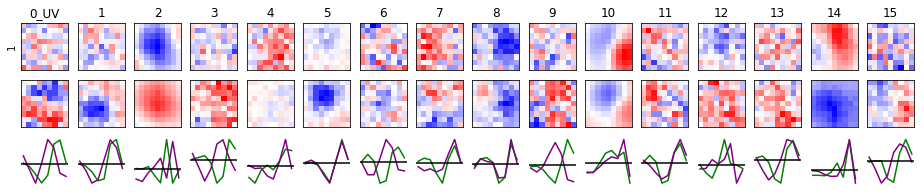

In [25]:
modelname=[6] # np.arange(1,10) #np.arange(1,3) [1,3,5,7]
plt.rcParams.update({'figure.max_open_warning': 0})
temptitle=1
for ii in range(len(modelname)):
    #print (ii)
    #print ('\n')
    #load model
    tempmodel= ModelSemiSL3d1_Conv3d_2()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_1_weight_'+str(modelname[ii])+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    #get parameters of model
    #conv3d_0=tempmodel.encoder[0].weight.cpu().data.numpy()
    conv3d_0=tempmodel.conv1.cpu().data.numpy()
    
    Vis_conv3d_0(conv3d_0,temptitle,save=False,\
        filename='out_result/20200429_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_weight_6_conv0_v5.svg')
    temptitle=temptitle+1
    torch.cuda.empty_cache()

In [26]:
#Use non-linear least squares to fit a 2d Gaussian function to conv0 and then measure the goodness of fit by r2
conv1_ss_s=[]
r2_s=[]
seeds=np.arange(1,11)
width,height=9,9
nt = 8 # time lag
ny = 9
nx = 9
dims = [nt, ny, nx]
for seed in seeds:
    tempmodel= ModelSemiSL3d1_Conv3d_2()
    tempmodel.load_state_dict(torch.load\
                ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_'+str(seed)+'_weight_6.pth'))
    tempmodel=tempmodel.to(device_cpu)
    conv3d_0=tempmodel.conv1.cpu().data.numpy() #shape (16,2,8,9,9)
    conv3d_0=np.reshape(conv3d_0,(-1,nt,ny,nx))
    for ii in range(len(conv3d_0)):
        [conv1_ss,_]=mySVD(conv3d_0[ii], dims)
        conv1_ss_s.append(conv1_ss)
conv1_ss_s=np.array(conv1_ss_s)
print (conv1_ss_s.shape)
conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
print (conv1_ss_s.shape)
#
for ii in range(len(conv1_ss_s)):
    fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
    fit_2dgaussian.fit()
    r2_s.append(fit_2dgaussian.cal_r2())
r2_s=np.array(r2_s)
print (np.median(r2_s))
print (np.mean(r2_s))

(320, 9, 9)
(320, 81)


/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.22828580027035078
0.34680377878027974


##  <font color='red'>after hyperparameter tuning</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100
LR=2e-4 # 1e-4
alpha1s = [1e2] 
alpha2s = [0] #not play a role
beta1s  =[1/16] 
alpha3s =[1e4] 
beta2s  =[1/16]
seeds   = [1]
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+1) #start from first seed
        modelname=str(jj+1) # modelname=1 and 9
        torch.manual_seed(seeds[ii])    
        torch.cuda.manual_seed(seeds[ii])
        
        tempmodel = ModelSemiSL3d1_Conv3d_2()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                alpha1=alpha1s[0],alpha2=alpha2s[0],\
                beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
        torch.save(tempmodel.state_dict(),\
               './out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

In [23]:
modelvalloss=np.zeros((10,9)) # 10 seeds x 9 weights
for ii in range(modelvalloss.shape[0]):
    seed_str=str(ii+1)
    for jj in range(modelvalloss.shape[1]):
        weight_str=str(jj+1)
        tempmodel = ModelSemiSL3d1_Conv3d_2()
        tempmodel.load_state_dict(torch.load\
            ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_'+seed_str+'_weight_'+weight_str+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss[ii,jj]=temp
print (modelvalloss)
print (np.mean(modelvalloss,axis=0))

[[0.28333559 0.28785238 0.2927108  0.29787267 0.30478274 0.31450452
  0.30761488 0.27997083 0.23363663]
 [0.28462862 0.28646555 0.29135074 0.29562779 0.30121475 0.30602723
  0.30131999 0.27870593 0.234766  ]
 [0.28650829 0.28979487 0.29254089 0.30051185 0.30642092 0.31000488
  0.30942749 0.29176755 0.23183413]
 [0.28392746 0.2869853  0.28971367 0.2929002  0.29979187 0.30759615
  0.30078314 0.27192796 0.23500123]
 [0.28609447 0.28915274 0.29372309 0.29827314 0.30445814 0.31256195
  0.30646621 0.28932903 0.23263487]
 [0.28371711 0.28833388 0.29348452 0.30178723 0.30905447 0.31913816
  0.31393094 0.28286244 0.23511474]
 [0.28638509 0.28785163 0.29319412 0.29766021 0.30454101 0.30952003
  0.3091879  0.27527002 0.23152029]
 [0.28560055 0.28792861 0.29121909 0.29473759 0.29955216 0.30511846
  0.30206705 0.27124819 0.23623497]
 [0.28368604 0.28719436 0.29065031 0.29792241 0.30271648 0.31160015
  0.30996422 0.27370431 0.23529309]
 [0.29201679 0.29331963 0.29556851 0.29915721 0.30542993 0.31106

Overall pearson correlation coefficient:  0.5392210895946  and p-value:  3.542583153527e-310
Overall pearson correlation coefficient:  0.5166244951821128  and p-value:  1.6268421733132303e-280
Overall pearson correlation coefficient:  0.49981172774987737  and p-value:  7.434522053844813e-260
Overall pearson correlation coefficient:  0.5133597903257696  and p-value:  2.0618529040894095e-276
Overall pearson correlation coefficient:  0.5198238631940824  and p-value:  1.4024441673018166e-284
Overall pearson correlation coefficient:  0.5394318104412408  and p-value:  1.82799180149017e-310
Overall pearson correlation coefficient:  0.5010519108406173  and p-value:  2.4351276467213356e-261
Overall pearson correlation coefficient:  0.5174885487450007  and p-value:  1.3120115314482368e-281
Overall pearson correlation coefficient:  0.5174225727090698  and p-value:  1.5905149033839828e-281
Overall pearson correlation coefficient:  0.5217290875897627  and p-value:  5.0787572016648904e-287
[0.539221

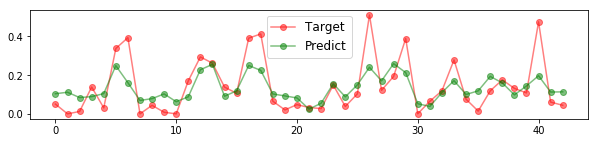

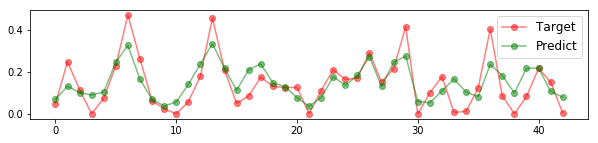

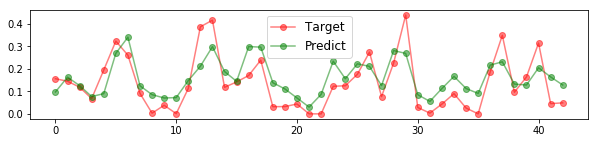

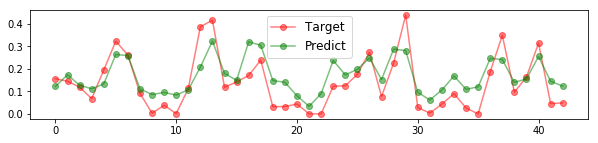

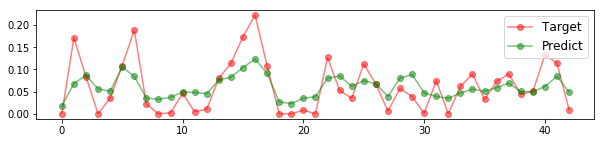

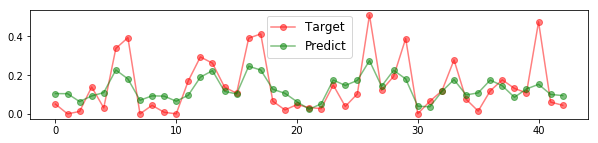

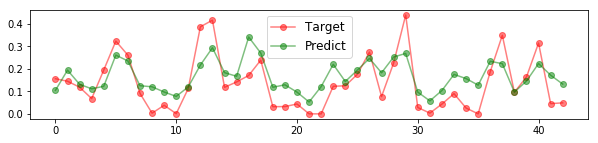

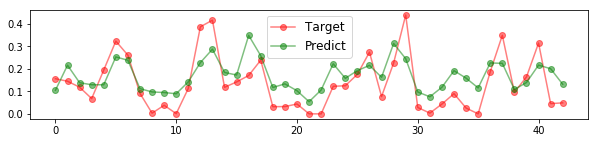

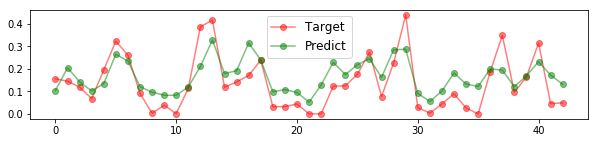

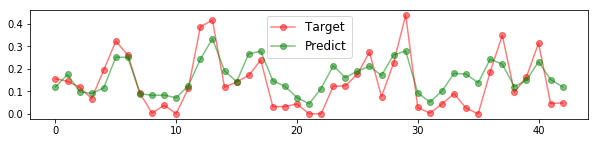

In [25]:
#test model
modeltestloss=[]
for ii in range(10):
    modelname=str(ii+1)
    tempmodel = ModelSemiSL3d1_Conv3d_2()
    tempmodel.load_state_dict(torch.load\
        ('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_'+modelname+'_weight_6'+'.pth'))
    tempmodel=tempmodel.to(device_cpu)
    CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
    modeltestloss.append(CC)

torch.cuda.empty_cache()
modeltestloss=np.array(modeltestloss)
print (modeltestloss)
print (np.mean(modeltestloss))

In [19]:
#save CCs for HNE with natural, pha-scr, noise
def model_test_save(model,data,device,use_pad0_sti=True):
    model=model.to(device)
    model=model.eval()
    (x,y,z)=data
    x=torch.from_numpy(x).float()
    b_x = x.to(device)
    z=z/255.0
    z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
    z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
    if 'Conv3d_1' in model.__class__.__name__:
        b_z = torch.from_numpy(z).float().to(device)
    elif 'Conv3d_2' in model.__class__.__name__:
        b_z = torch.from_numpy(z).float().to(device)
        b_z[:,:,-1,:,:]=0 # 7th frame is set to 0 after preprocessing
    #
    with torch.no_grad():
        if 'Semi' in model.__class__.__name__:
            encoded,_,_ = model(b_x,b_z)
        else:
            encoded = model(b_x)
    encoded_np=encoded.cpu().data.numpy()
    if use_pad0_sti==False: # do not use reponses of 0-padding stimulus, here 7 because we use 8 time lags
        encoded_np=encoded_np[7:,:]
        y=y[7:,:]
    testccs=np.zeros((encoded_np.shape[1]))
    for ii in range(encoded_np.shape[1]):
        testccs[ii],testpvalue=pearsonr(encoded_np[:,ii], y[:,ii])
    print (np.median(testccs))
    return testccs
#upandlow
tempmodel= ModelSemiSL3d1_Conv3d_2()
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_1_weight_6'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
CCs=model_test_save(tempmodel,test_loader,device_cpu,use_pad0_sti=False)

0.4886940880247309


(96, 2, 8, 28, 28)


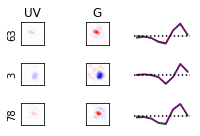

In [22]:
# save svd results of example neuronal RFs
nt = 8 # time lag
ny = 28
nx = 28
dims = [nt, ny, nx]
#
#visualize final layer of model
tempmodel= ModelSemiSL3d1_Conv3d_2()
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_1_weight_6'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1  =tempmodel.conv1.data.clone().detach()
conv1_bias   =tempmodel.conv1_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
tempmodel= ModelSemiSL3d1_Conv3d_2_copy(conv1,conv1_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,8,28,28))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[63,3,78] #np.arange(len(RF_fl_np)) #
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

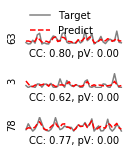

In [24]:
#plot prediction results for example neurons
tempmodel= ModelSemiSL3d1_Conv3d_2()
tempmodel.load_state_dict(torch.load('./out/20200429_v5_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_seed_1_weight_6'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y,z)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu)
z=z/255.0
z[:,0,:,:,:]=z[:,0,:,:,:]-sky_bg_mean_f[0]
z[:,1,:,:,:]=z[:,1,:,:,:]-sky_bg_mean_f[1]
if 'Conv3d_1' in tempmodel.__class__.__name__:
    b_z = torch.from_numpy(z).float().to(device_cpu)
elif 'Conv3d_2' in tempmodel.__class__.__name__:
    b_z = torch.from_numpy(z).float().to(device_cpu)
    b_z[:,:,-1,:,:]=0 # 7th frame is set to 0 after preprocessing
with torch.no_grad():
    encoded,_,_ = tempmodel(b_x,b_z)
encoded_np=encoded.cpu().data.numpy()
encoded_np=encoded_np[7:,:] #use_pad0_sti=False
y=y[7:,:] #use_pad0_sti=False
#
nums_eg=[63,3,78] 
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.1)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='red',linestyle='--',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()